(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

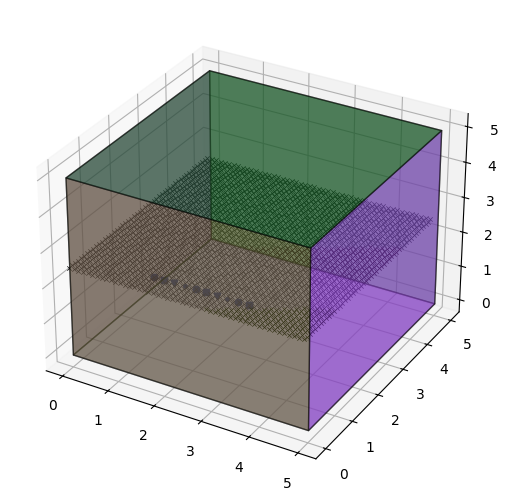

In [8]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Setup Anechoic Room to neglect room effects and simplify
fs = 16000
room_dim = [5.0, 5.0, 5.0]
room = pra.ShoeBox(room_dim, fs=fs, max_order=3, air_absorption=True)

# Speaker Setup: A 5-speaker linear array | Pyroomacoustics uses 3D coordinates, so we set Z=0
num_speakers = 10
speaker_x = np.linspace(1.5, 3.5, num_speakers)
speaker_locs = np.vstack((speaker_x, np.full(num_speakers, 0.5), np.full(num_speakers, 2.5)))

for loc in speaker_locs.T:
    room.add_source(loc)

# Microphone Grid
spacing = 0.1
x_coords = np.arange(0, 5.0, spacing)
y_coords = np.arange(0, 5.0, spacing)
X, Y = np.meshgrid(x_coords, y_coords)
mics_locs = np.vstack((X.flatten(), Y.flatten(), np.full(X.size, 2.5)))
mic_array = pra.MicrophoneArray(mics_locs, room.fs)
room.add_microphone_array(mic_array)

# Plotting
room.plot()

In [9]:
# Calculate H for a given frequency
target_freq = 500
c = pra.constants.get('c') # Speed of sound
k = 2 * np.pi * target_freq / c

# Compute RIR and create empty H
room.compute_rir()
num_mics = mics_locs.shape[1]
H = np.zeros((num_mics, num_speakers), dtype=complex)

# Set FFT params
nfft = 8192 
freq_bin = int((target_freq / fs) * nfft)

# Populate H
for m in range(num_mics):
    for s in range(num_speakers):
        rir_time_domain = room.rir[m][s]
        h_freq = np.fft.rfft(rir_time_domain, n=nfft)
        H[m, s] = h_freq[freq_bin]

# Define Bright and Dark Zones by left/right side of the room
if False:
    bright_indices = np.where(mics_locs[0, :] < 2.5)[0]
    dark_indices = np.where(mics_locs[0, :] >= 2.5)[0]

# Define the centers and radius for the circular zones
if True:
    radius = 0.5
    bright_center = np.array([1.5, 3.0])
    dark_center = np.array([3.5, 3.0])
    dist_to_bright = np.sqrt((mics_locs[0, :] - bright_center[0])**2 + (mics_locs[1, :] - bright_center[1])**2)
    dist_to_dark = np.sqrt((mics_locs[0, :] - dark_center[0])**2 + (mics_locs[1, :] - dark_center[1])**2)
    bright_indices = np.where(dist_to_bright <= radius)[0]
    dark_indices = np.where(dist_to_dark <= radius)[0]

Hb = H[bright_indices, :]
Hd = H[dark_indices, :]

# The ACC Math 
lambda_reg = 1e-2 # Regularization to limit "array effort"
R_dark = Hd.conj().T @ Hd + lambda_reg * np.eye(num_speakers)
R_bright = Hb.conj().T @ Hb

# Find the eigenvectors, optimal weights are the eigenvector corresponding to the largest eigenvalue
vals, vecs = eig(R_bright, R_dark)
optimal_g = vecs[:, np.argmax(np.real(vals))]

/Users/felipeabedrapo/University/spectral-analysis/sound-zones/.venv_sound/lib/python3.11/site-packages/pyroomacoustics/simulation/ism.py:187: RuntimeWarning: divide by zero encountered in divide
  oct_band_amplitude = att / dist


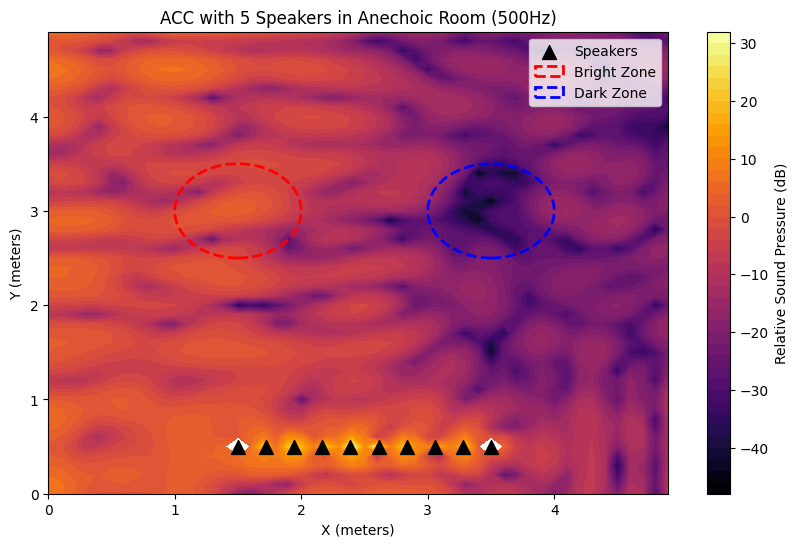

In [10]:
# Multiply the transfer functions by our optimal speaker weights
p = H @ optimal_g
pressure_map = np.abs(p).reshape(X.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, 20 * np.log10(pressure_map.clip(-80, 40)), levels=50, cmap='inferno')
plt.colorbar(label="Relative Sound Pressure (dB)")

# Overlay speakers and the zone boundary
plt.scatter(speaker_locs[0, :], speaker_locs[1, :], color='black', label='Speakers', marker='^', s=100)

# Draw the Bright Zone circle (Left)
bright_circle = plt.Circle(bright_center, radius, color='red', fill=False, linestyle='--', linewidth=2, label='Bright Zone')
plt.gca().add_patch(bright_circle)

# Draw the Dark Zone circle (Right)
dark_circle = plt.Circle(dark_center, radius, color='blue', fill=False, linestyle='--', linewidth=2, label='Dark Zone')
plt.gca().add_patch(dark_circle)

# plt.axvline(2.5, color='black', linestyle='--', label='Zone Boundary')

plt.title(f"ACC with 5 Speakers in Anechoic Room ({target_freq}Hz)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.show()